In [1]:
#if you have not installed tabulate 
#this is just for printing the information of data in a prettier format
! pip install tabulate

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Testing Function

In [4]:
#import main code
from OurTrainingTools import *
#this will throw a random number and print it
#to reset the random number manually, use
#torch.manual_seed(random_seed)


def test_model(madminermodel, test_input_sm, test_input_bsm, bsmparval, NSM, NBSM, epochs, e, n_meas, pm, verbose_t=True, verbose_period_t=1e5, title=''):
        
        # computing test statistics t (or lambda) in equation (2) of paper
        def compute_t(madminermodel, nev, counter, test_input):
            # generate number of points for testing under Poisson distribution
            n_gen = 0
            while n_gen == 0:
                n_gen = np.random.poisson(nev)
            
            # stop if there are no more points to test
            if (counter + n_gen) >= len(test_input):
                return 0., -1
            
            points = test_input[int(counter): int(counter+n_gen)]
            
            # compute test statistics
            log_ratio = (madminermodel.evaluate_log_likelihood_ratio(points.numpy(), 
                                            np.array([bsmparval,]))[0][0])
            log_ratio = torch.tensor(log_ratio)
            #ratio = 1./ratio
            log_ratio = log_ratio
            out  = 2 * (NBSM - NSM - (log_ratio+torch.log(torch.tensor(NBSM/NSM))).sum(0))
            
            #return test statistics and the starting point for the next batch
            return out, int(counter+n_gen)
        
        test_start = time.time()
        if verbose_t:
            print("NSM = %.3f --- NBSM = %.3f"%(NSM, NBSM))
        tsm  = torch.empty(n_meas)
        tbsm = torch.empty(n_meas)
        
        # empty array to store values
        tsmcount  = torch.zeros(n_meas+1)
        tbsmcount = torch.zeros(n_meas+1)
            
        for i in range(n_meas):
            tsm[i], tsmcount[i+1] = compute_t(madminermodel, NSM, tsmcount[i], 
                                       test_input_sm)
            tbsm[i], tbsmcount[i+1] = compute_t(madminermodel, NBSM, tbsmcount[i], 
                                       test_input_bsm)
            
            if (tsmcount[i+1] < 0) or (tbsmcount[i+1] < 0):
                print('Reaching the end of test data. Stop tests at %d. '%i)
                tsm, tbsm = tsm[: i], tbsm[: i]
                n_meas = i
                break
                
            if i % (verbose_period_t) == 0:
                print('test %s: tsm = %.3f,  tbsm = %.3f'%(
                        str(i).ljust(4), tsm[i], tbsm[i]))
        
        test_duration = time.time() - test_start
        
        #compute mean and variation of the test statistics in two hypotheses
        mu_sm     = tsm.mean().item()
        mu_bsm    = tbsm.mean().item()
        sigma_sm  = tsm.std().item()
        sigma_bsm = tbsm.std().item()
        med_sm    = tsm.median().item()
        
        #compute separation and p-value
        sep    = (mu_sm - mu_bsm)/sigma_bsm
        p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm) 
        #print(len([i for i in tbsm if i>med_sm]))
        delta1 = (p * (1 - p)/n_meas)**0.5
        delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
                2 * sigma_bsm**2))/(2*(n_meas**0.5))
        print('===> delta1 = %.3f, delta2 = %.3f'%(delta1, delta2))
        deltap = (delta1**2 + delta2**2)**0.5
        
        results_path = os.getcwd()
        
        if verbose_t:
            print('p = %.3f +/- %.3f' %(p, deltap))
            print('Separation = %.2f sigmas'%(sep))
            training_properties = '/toydata/madminer-carl-'+title
            plot_histogram(tsm, tbsm, int(NSM), int(NBSM), p, deltap, sep, epochs, e, 
                                training_properties, results_path)
            print('Partial test after %d epochs (took %.2f seconds)\n'
                          %(e, test_duration))
            
        
        return sep, p

In [5]:
def plot_histogram(tsm, tbsm, nsm, nbsm, p, deltap, sep, epochs, 
                   e, training_properties, results_folder):
    mint = torch.min(torch.cat((tsm, tbsm))).item()
    maxt = torch.max(torch.cat((tsm, tbsm))).item()
    
    # for some reason the code complains if i don't detach the variables 
    # from their grad-on versions
    tsm, tbsm = tsm.detach(), tbsm.detach()
    
    bins = np.linspace(mint, maxt, 60)
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    plt.hist(tsm,  bins, alpha=0.5, label='SM')
    plt.hist(tbsm, bins, alpha=0.5, label='BSM')
    plt.legend(loc='upper right')
    
    sn   = 'nsm = %s \nnbsm = %s'%(str(nsm), str(nbsm))
    sp   = 'p      '+'= '+ ('%.3f +/- %.3f'%(p, deltap))
    ssep = 'sep   ' + '= ' + ('%.3f'%(sep))
    
    plt.text(x=0.05, y=0.85, transform=ax.transAxes, 
         s=sn+'\n'+sp+'\n'+ssep, bbox=dict(facecolor='blue', alpha=0.2))
    plt.xlabel('t')
    plt.ylabel('p(t)')
    if epochs == e:
        plt.title('Final test\n' + training_properties)
        filename = results_folder + training_properties \
                    + ' histogram.pdf'
        plt.savefig(filename)
        return 
    plt.title(training_properties)
    plt.show()
    
    return

In [6]:
def TestEstimator(gphival, gphival_name='', withXS=True, title_message=''):
    
    #toy data file path
    if not gphival_name:
        gphival_name = gphival
    f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%s_out.h5'%(gphival_name), 'r')

    #parse data 
    Data = np.array(f['Data'])
    Labels = np.array(f['Labels'])
    NSM = np.array(f['NSM'])
    
    if withXS:
        NBSMList = np.array(f['NBSMList'])
        NBSM = NBSMList[0]
    else:
        NBSM = NSM
        
    #randomise
    Idx_test = torch.randperm(len(Data))
    Data_test = torch.Tensor(Data[Idx_test])
    Label_test = torch.Tensor(Labels[Idx_test])

    #select data from each hypothesis
    SM_Data  = Data_test[Label_test==0, :]
    BSM_Data = Data_test[Label_test==1, :]

    #for plotting/ printing
    n_epochs = current_epoch = int(1e4)
    results_path = os.getcwd()
    charge = 'plus'

    #number of tests thrown on the data
    #the test function will stop automatically if points run out
    n_meas = 4000

    if withXS:
        sep, p = test_model(estimator, SM_Data, BSM_Data, gphival, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
              verbose_t=True, verbose_period_t=1e5, title='gphi%s_new'%(gphival_name)+title_message)
    else:
        sep, p = test_model(estimator, SM_Data, BSM_Data, gphival, NSM, NBSM, n_epochs, current_epoch, n_meas, charge, 
              verbose_t=True, verbose_period_t=1e5, title='gphi%s_new_equalXS'%(gphival_name)+title_message)
        
    f.close()
    
    return sep, p

## Reading Model

In [7]:
from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

Evaluating with knowledge on the Cross Section, gphi=35e-1
NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = 974.402,  tbsm = 1023.880
Reaching the end of test data. Stop tests at 221. 
===> delta1 = 0.032, delta2 = 0.029
p = 0.344 +/- 0.043
Separation = 0.40 sigmas
Partial test after 10000 epochs (took 89.21 seconds)

Evaluating without knowledge on the Cross Section, gphi=35e-1
NSM = 2225.504 --- NBSM = 2225.504
test 0   : tsm = 852.413,  tbsm = 981.419
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.031, delta2 = 0.027
p = 0.304 +/- 0.041
Separation = 0.55 sigmas
Partial test after 10000 epochs (took 80.06 seconds)

Evaluating with knowledge on the Cross Section, gphi=5
NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 1909.771,  tbsm = 1729.189
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.030, delta2 = 0.030
p = 0.279 +/- 0.042
Separation = 0.55 sigmas
Partial test after 10000 epochs (took 78.67 seconds)

Evaluating without knowledge on 

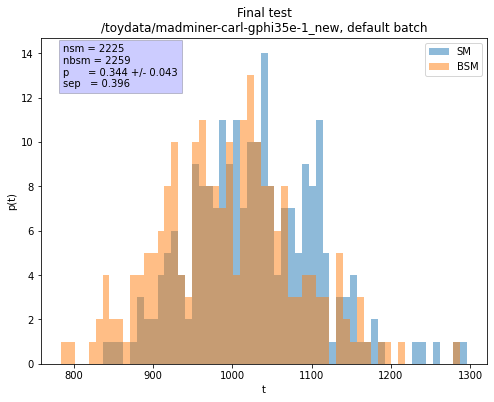

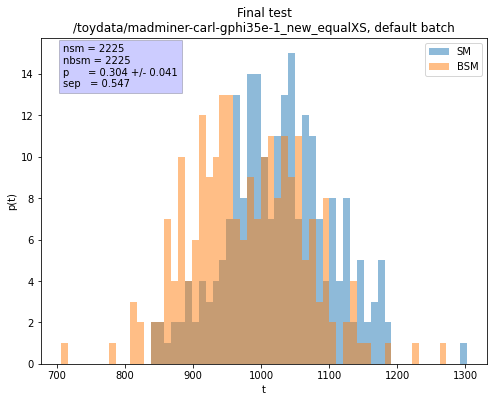

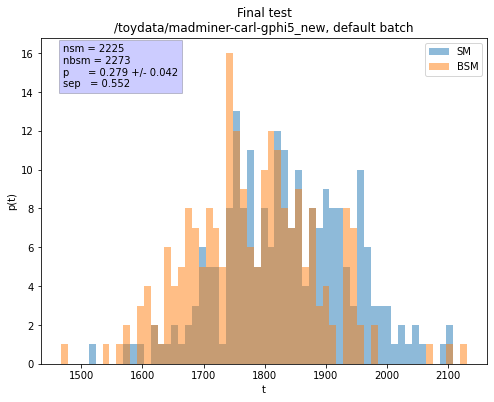

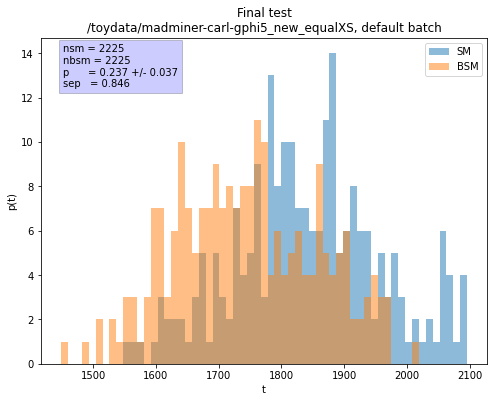

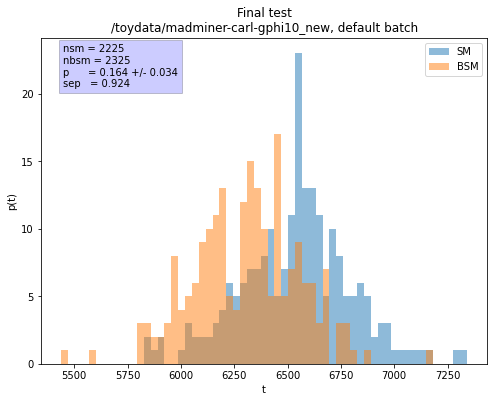

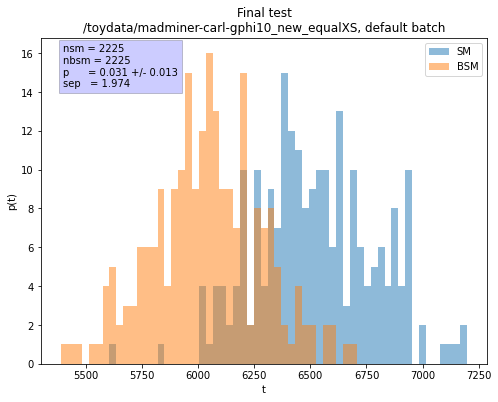

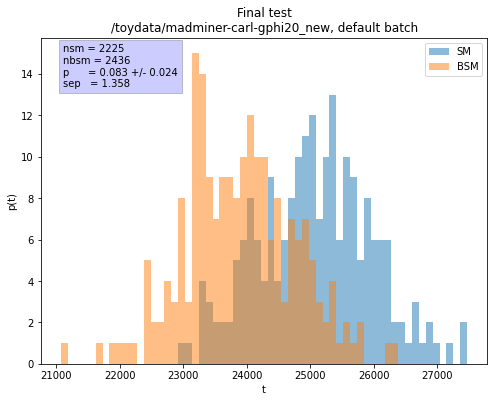

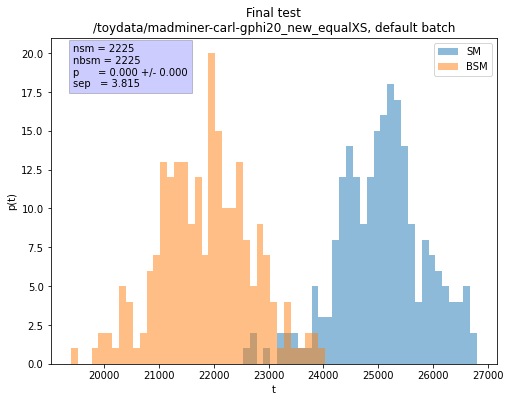

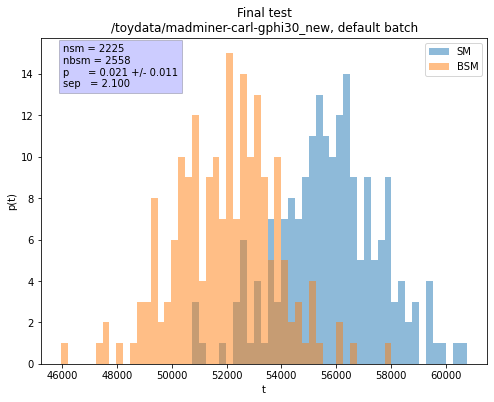

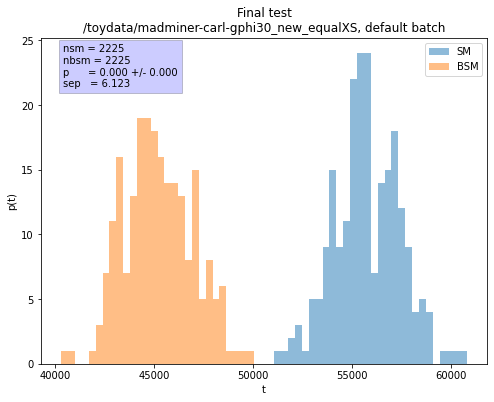

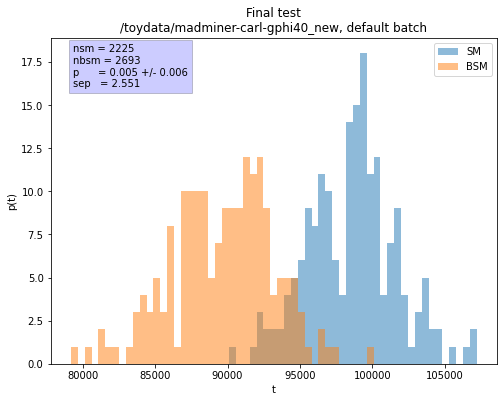

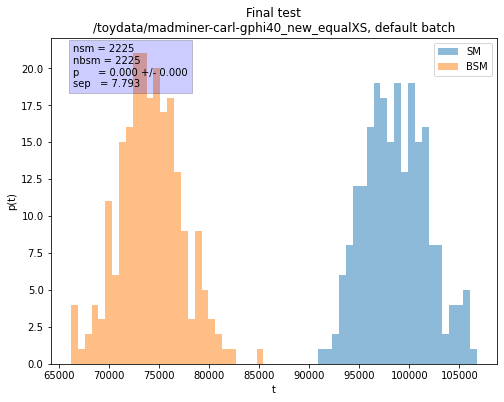

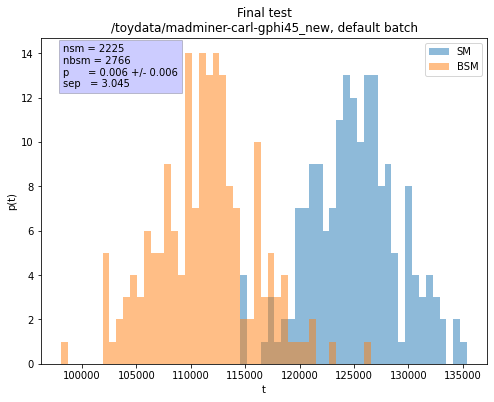

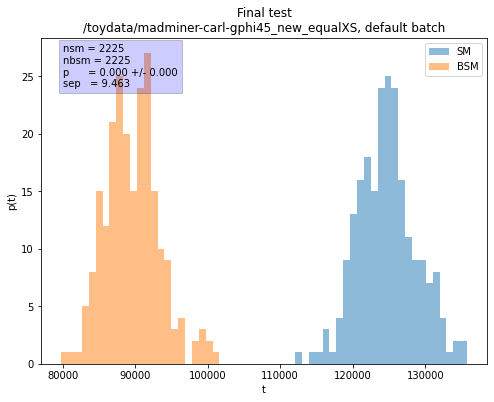

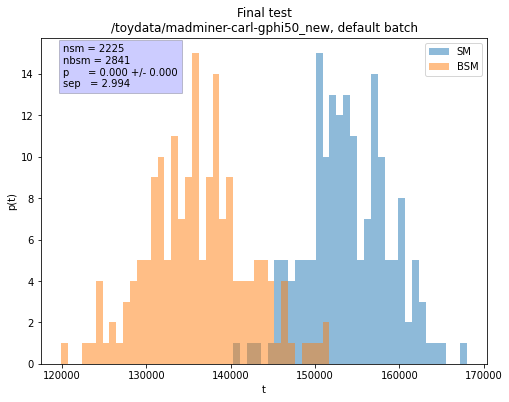

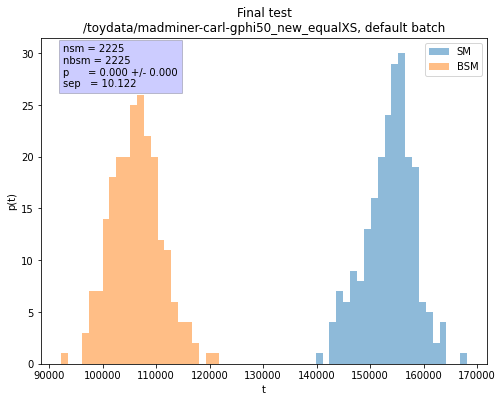

In [8]:
#Wilson coefficient value (*10^-2 TeV^-2)
gphivals = [35e-1, 5, 10, 20, 30, 40, 45, 50]
gphival_names = ['35e-1', '5', '10', '20', '30', '40', '45', '50']
seps, ps = [], []
seps_alt, ps_alt = [], []


for (gphival, gphival_name) in zip(gphivals, gphival_names):
    print('Evaluating with knowledge on the Cross Section, gphi=%s'%(gphival_name))
    result = TestEstimator(gphival, gphival_name, title_message=', default batch')
    seps.append(result[0])
    ps.append(result[1])
    
    print('Evaluating without knowledge on the Cross Section, gphi=%s'%(gphival_name))
    result = TestEstimator(gphival, gphival_name, withXS=False, title_message=', default batch')
    seps_alt.append(result[0])
    ps_alt.append(result[1])
    

In [9]:
from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl1000-bigbatch')

Evaluating with knowledge on the Cross Section, gphi=35e-1
NSM = 2225.504 --- NBSM = 2259.447
test 0   : tsm = 832.459,  tbsm = 750.826
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.027, delta2 = 0.026
p = 0.195 +/- 0.037
Separation = 0.77 sigmas
Partial test after 10000 epochs (took 77.82 seconds)

Evaluating without knowledge on the Cross Section, gphi=35e-1
NSM = 2225.504 --- NBSM = 2225.504
test 0   : tsm = 750.433,  tbsm = 839.760
Reaching the end of test data. Stop tests at 224. 
===> delta1 = 0.025, delta2 = 0.019
p = 0.174 +/- 0.032
Separation = 1.03 sigmas
Partial test after 10000 epochs (took 79.94 seconds)

Evaluating with knowledge on the Cross Section, gphi=5
NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 1438.222,  tbsm = 1335.216
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.028, delta2 = 0.022
p = 0.224 +/- 0.036
Separation = 0.78 sigmas
Partial test after 10000 epochs (took 78.69 seconds)

Evaluating without knowledge on t

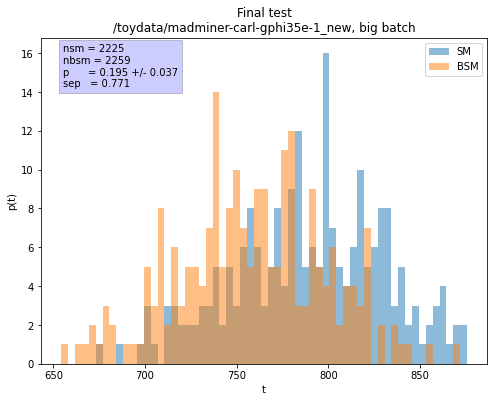

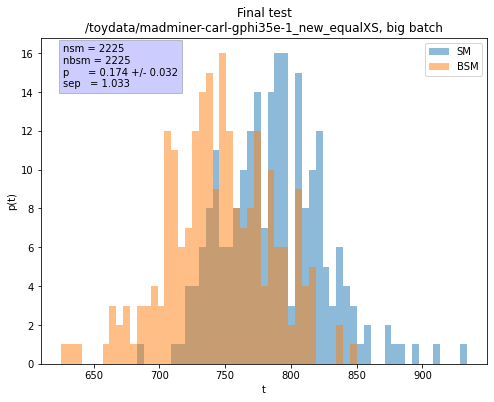

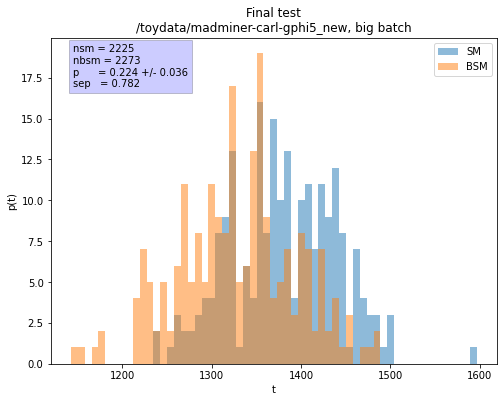

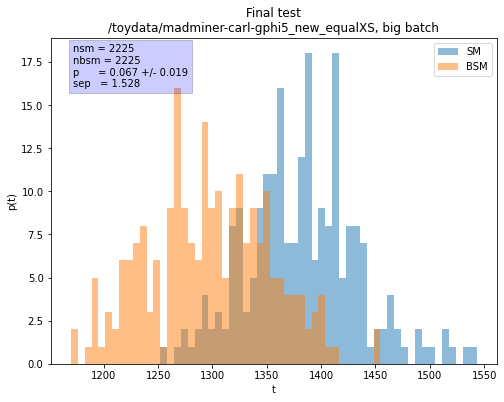

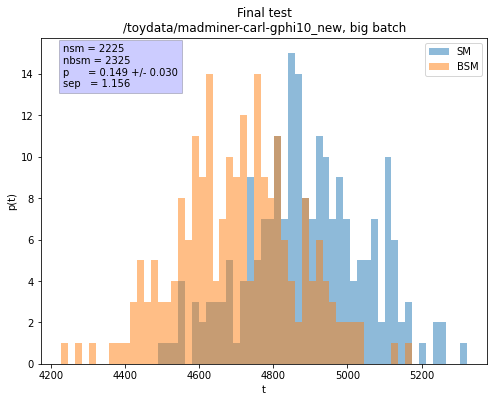

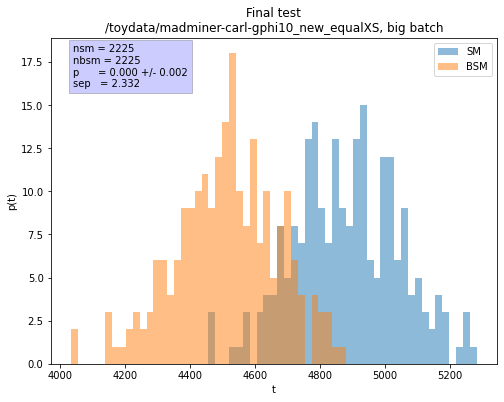

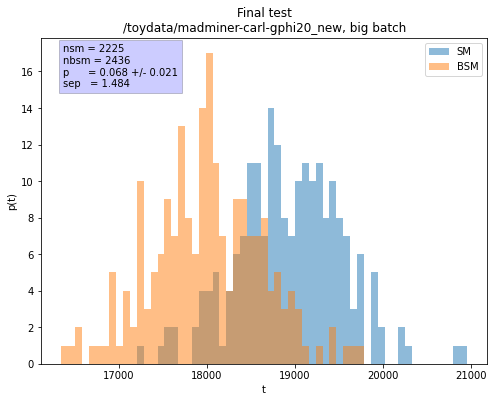

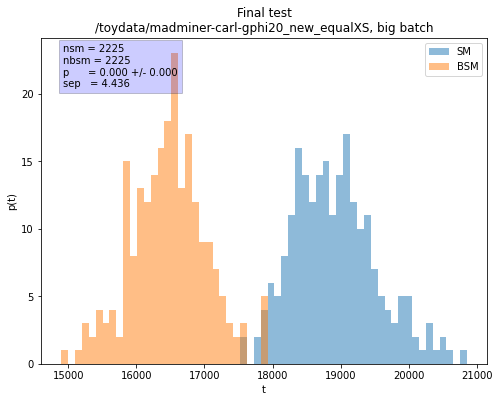

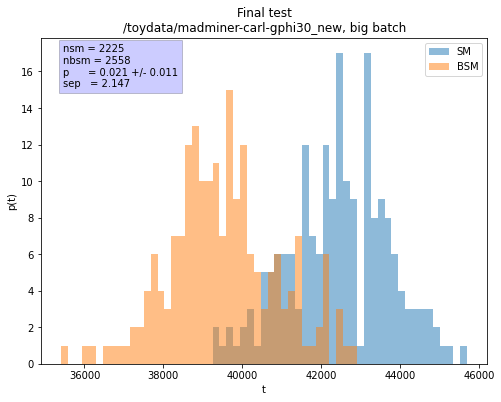

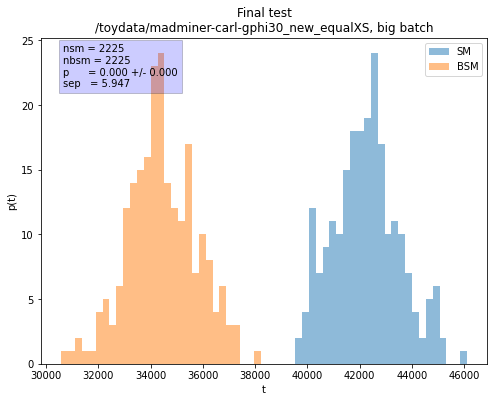

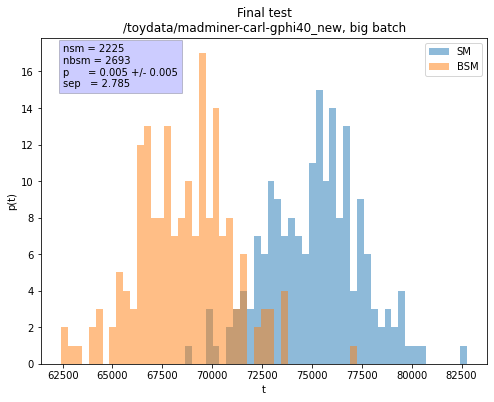

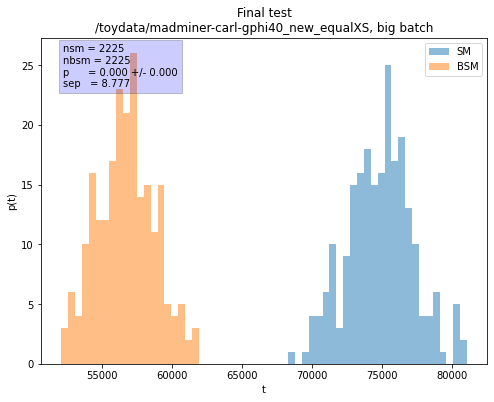

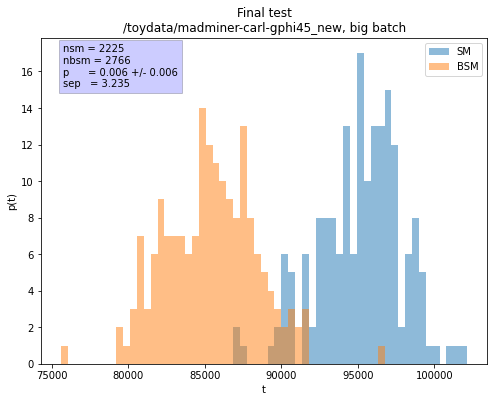

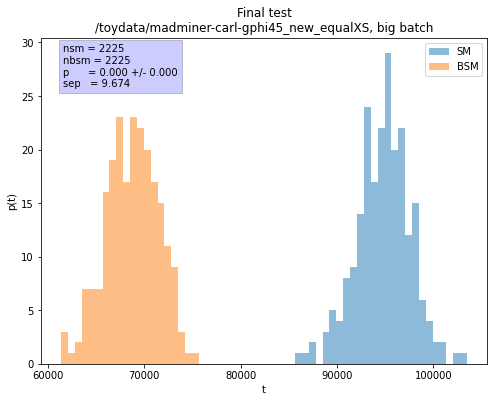

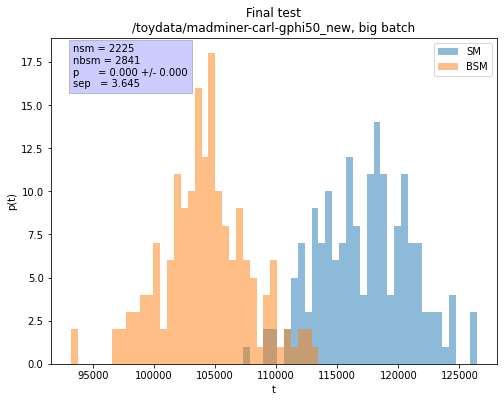

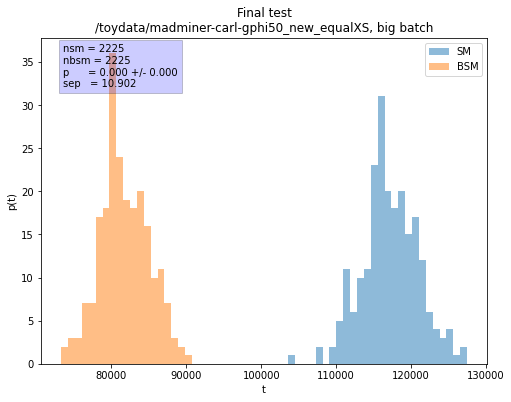

In [10]:
#Wilson coefficient value (*10^-2 TeV^-2)
gphivals = [35e-1, 5, 10, 20, 30, 40, 45, 50]
gphival_names = ['35e-1', '5', '10', '20', '30', '40', '45', '50']
seps_new, ps_new = [], []
seps_alt_new, ps_alt_new = [], []


for (gphival, gphival_name) in zip(gphivals, gphival_names):
    print('Evaluating with knowledge on the Cross Section, gphi=%s'%(gphival_name))
    result = TestEstimator(gphival, gphival_name, title_message=', big batch')
    seps_new.append(result[0])
    ps_new.append(result[1])
    
    print('Evaluating without knowledge on the Cross Section, gphi=%s'%(gphival_name))
    result = TestEstimator(gphival, gphival_name, withXS=False, title_message=', big batch')
    seps_alt_new.append(result[0])
    ps_alt_new.append(result[1])
    

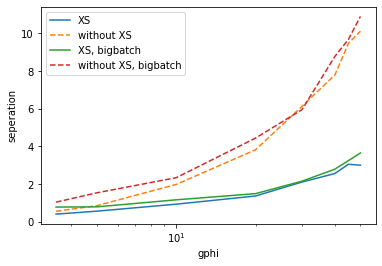

In [11]:
plt.plot(gphivals, seps, label='XS')
plt.plot(gphivals, seps_alt, '--', label='without XS')
plt.plot(gphivals, seps_new, label='XS, bigbatch')
plt.plot(gphivals, seps_alt_new, '--', label='without XS, bigbatch')
plt.xscale('log')
plt.xlabel('gphi')
plt.ylabel('seperation')
plt.legend()

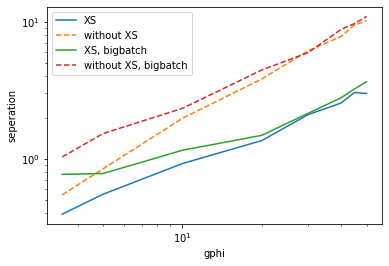

In [12]:
plt.plot(gphivals, seps, label='XS')
plt.plot(gphivals, seps_alt, '--', label='without XS')
plt.plot(gphivals, seps_new, label='XS, bigbatch')
plt.plot(gphivals, seps_alt_new, '--', label='without XS, bigbatch')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('gphi')
plt.ylabel('seperation')
plt.legend()

In [ ]:
TestEstimator(3.5, '35e-4')

In [ ]:
TestEstimator(3.5, '35e-4', False)